# Super-resolución 2x:
## Modelado y Entranamiento:

Ejercicio de curso para la asignatura de Computación Inteligente perteneciente al Máster Universitario en Sistemas Inteligentes y Aplicaciones Numéricas para la Ingeniería (MUSIANI) en el curso 2020/21, realizado por Juan Sebastián Ramírez Artiles.

El ejercicio consiste en implementar un método de superresolución en imágenes basado en el método VDSR descrito en el artículo [Superresolución de una sola imagen mediante el aprendizaje profundo](https://es.mathworks.com/help/images/single-image-super-resolution-using-deep-learning.html). Concretamente, en este notebook se ha implementado un escalado de dos aumententos. El dataset usado fue el [ffhq-dataset](https://drive.google.com/drive/folders/1u2xu7bSrWxrbUxk-dT-UvEJq8IjdmNTP) de libre descarga. Las imgágenes usadas son las del conjunto 64000 con un tamaño para las imágenes de alta resolución de a 1024x1024, y de 128x128 para las de baja resolución. Para la realización de este ejercicio se ha reducido las imágenes de alta resolución a 256x256 de modo que serán las que se usarán como etiquetas de la red.


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import torch.optim as optim
from os import listdir
from os.path import join
from PIL import Image

Las imágenes se cargan de cuatro directorios. Las imágenes reales se situan en train_y y valid_y, mientras que las imágenes a ampliar se encuentran en los directorios train_x y valid_x.

El programa se ejecutó en una máquina con un procesador Intel Core i7-7700HQ a 2.80GHz con una tarjeta de vídeo NVIDIA GeForce GTX 1050 de 4GB de memoria dedicada y con 32 GB de memoria RAM.

![](Super_Resolution_CI_3.1.JPG)

In [2]:
ngpu = 1
beta1 = 0.5
lr = 0.005
bs = 150
epochs = 50

path_train_x = "faces/train_x/x8"
path_train_y = "faces/train_y/x4"

path_valid_x = "faces/valid_x/x8"
path_valid_y = "faces/valid_y/x4"

El entrenamiento del modelo se realizó únicamente en la capa de luminancia mientras que las capas de crominancia se escalaron por el método tradicional. El resultado final no se verá perjudicado en exceso, ya que las crominancias influyen mínimamente en la calidad del contorno. Para lograr este objetivo se hizo necesario convertir las imágenes de RGB a YCbCr.

Para la generación del dataset y las transformaciones del mismo se usó como modelo el ejemplo publicado en la web de pytorch [Writting custom datasets, dataloaders and transforms](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

In [3]:
class FacesDataset(Dataset):
    
    def __init__(self, root_dir_x, root_dir_y, transform=None):
        self.x_files = listdir(root_dir_x)
        self.y_files = listdir(root_dir_y)
        
        assert  len(self.x_files) == len(self.x_files)
        
        self.dir_x = root_dir_x
        self.dir_y = root_dir_y
        
        self.transform = transform

    def __len__(self):
        return len(self.x_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
                
        img_x = Image.open(join(self.dir_x, self.x_files[idx]))
        img_y = Image.open(join(self.dir_y, self.y_files[idx]))
                
        img_set = {'img_x': img_x, 'img_y': img_y}
        
        if self.transform:
            img_set = self.transform(img_set)

        return img_set

In [4]:
class PilToYCbCr(object):
    def __call__(self, img_set):
        imgs = []
        
        for _, img in img_set.items():            
            imgs.append(img.convert('YCbCr'))
            
        return {'img_x': imgs[0], 'img_y': imgs[1]}

In [5]:
class ToTensor(object):
    def __call__(self, img_set):
        
        imgs = []
                
        for _, img in img_set.items():
            tr = transforms.ToTensor()
            imgs.append(tr(img))
        
        return { 'img_x': imgs[0], 'img_y': imgs[1] }

In [6]:
class Normalize(object):
    def __call__(self, img_set):
        imgs = []
        mean = torch.Tensor([0.5])
        std = 0.5
        
        for _, img in img_set.items():
            
            img = (img - mean.expand_as(img)) / std
            imgs.append(img)
        
        return {'img_x': imgs[0], 'img_y': imgs[1]}

In [7]:
transform = transforms.Compose([
    PilToYCbCr(),
    ToTensor(),
    Normalize()
])

imgs_train = FacesDataset(path_train_x, path_train_y, transform = transform)
imgs_valid = FacesDataset(path_valid_x, path_valid_y, transform = transform)

In [8]:
imgs_train_dl = DataLoader(imgs_train, batch_size = bs, shuffle = True)
imgs_valid_dl = DataLoader(imgs_valid, batch_size = bs, shuffle = True)

El dataset se dividió en 900 imágenes para entrenamiento y 100 imágenes para validación.

In [9]:
print(len(imgs_train))
print(len(imgs_valid))

900
100


In [10]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

Se probaron una variedad de modelos diferentes. Se usaron kernels de 3x3, de 5x5 y de 7x7, siendo estos últimos los que mejor resultados dieron. También se probaron diferentes configuraciones de red, añadiendo capas convolutivas y modificando las funciones de activación. Esta configuración resultó la más adecuada.

En el proceso de entrenamiento se usaron gran variedad de combinaciones de tamaños de batches y de cantidad de épocas. Se empezó con tamaños de batch de 8, se fue subiendo hasta 150, dejando todavía 900 MB de espacio en GPU. En cuanto al número de épocas, se empezó con 10 iteraciones y se fue subiendo hasta la cantidad de 80. No obstante, al variar el learning rate se aceleró la convergencia, con lo que finalmente se bajó a 50 épocas.

In [11]:
class SuperResolution(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 8, kernel_size = 7, padding = 3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size = 7, padding = 3)
        self.conv3 = nn.Conv2d(16, 8, kernel_size = 7, padding = 3)
        self.conv4 = nn.Conv2d(8, 1, kernel_size = 7, padding = 3)
        
        self.upsample = nn.Upsample(scale_factor = 2)

    def forward(self, xb):
        
        xb = self.upsample(xb)
        xb = torch.tanh(self.conv1(xb))
        xb = torch.tanh(self.conv2(xb))
        xb = torch.tanh(self.conv3(xb))
        
        return torch.tanh(self.conv4(xb))

In [12]:
def preprocess(x, y):
    return x.to(device), y.to(device)

In [13]:
def get_model():
    model = SuperResolution().to(device)
    return model, optim.SGD(model.parameters(), lr=lr, momentum=0.9)

loss_func = nn.MSELoss(reduction='mean')

In [14]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
    
    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for sample_batch in imgs_train_dl:
            yield (self.func(sample_batch['img_x'][:,0].unsqueeze(-3), sample_batch['img_y'][:,0].unsqueeze(-3)))        

In [15]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.item(), len(xb)

In [16]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, val_losses):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_losses.append(val_loss)
        
        print(epoch, val_loss)

In [17]:
train_dl = WrappedDataLoader(imgs_train, preprocess)
valid_dl = WrappedDataLoader(imgs_valid, preprocess)

val_losses = []

model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl, val_losses)

0 0.06483114262421925
1 0.035555280124147735
2 0.0427752248942852
3 0.03147281768421332
4 0.02484137626985709
5 0.021126075958212216
6 0.018905918424328167
7 0.017399668072660763
8 0.016367529518902302
9 0.015588741439084211
10 0.015041750855743885
11 0.014637039974331856
12 0.014345746797819933
13 0.014098256515959898
14 0.01389435213059187
15 0.01372075593098998
16 0.013559625639269749
17 0.013407290602723757
18 0.01325499452650547
19 0.013114516157656908
20 0.012972752408434948
21 0.012838196940720081
22 0.012711273195842901
23 0.012588480021804571
24 0.012473906545589367
25 0.012338769932587942
26 0.012223247438669205
27 0.012106362575044235
28 0.012000804767012596
29 0.011903391685336828
30 0.011786489437023798
31 0.011673237973203262
32 0.0115752339673539
33 0.01147368069117268
34 0.011375766557951769
35 0.011281569954007864
36 0.011192037568738064
37 0.011095528801282247
38 0.01100900707145532
39 0.010920462508996328
40 0.01083372626453638
41 0.0107595583734413
42 0.010702791158

Se puede observar en el gráfico que la red aprende bien.

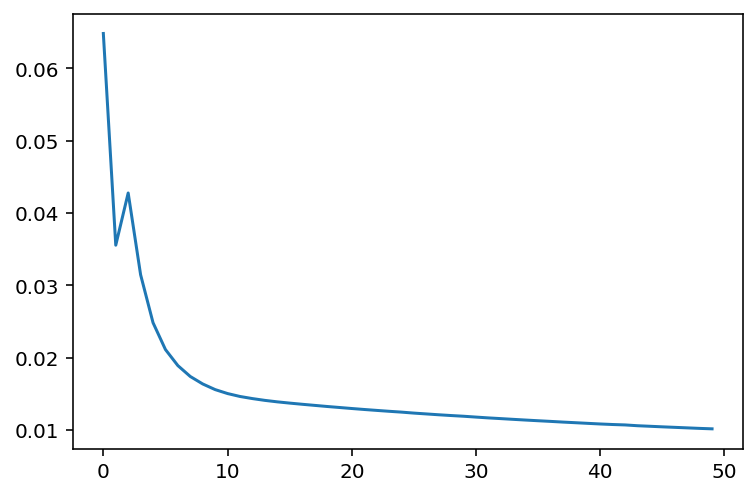

In [18]:
plt.plot(val_losses)
plt.show()

Para finalizar, salvo el modelo para poder usarlo en el notebook [SR_Restore_Faces_Model.ipynb](SR_Restore_Faces_Model.ipynb) que se encargará de escalar las 100 imágenes de validación. - Modelo entrenado [SR_model_Faces_5.0.ml](SR_model_Faces_5.0.ml) -

In [19]:
torch.save(model, "SR_model_Faces_5.0.ml")

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>